# <span style="color:blue">Import Required Libraries</span>

In [1]:
# import some require library
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import os
os.environ['SSL_CERT_FILE'] = '/etc/ssl/certs/ca-certificates.crt'

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# <span style="color:blue">Customize Image Dataset</span>

## CustomImageDataset Class

Represents a custom dataset of images. Each method collectively handles dataset initialization, data access, and feature vector processing, providing core functionalities required for working with the CustomImageDataset class.

 `__init__(self, root_dir, transform=None, include_feature_vector=True)`

- Initializes the dataset with the root directory where images are stored, an optional transformation to be applied to the images, and a boolean flag to include pre-computed feature vectors.

 `__len__(self)`

- Returns the total number of images in the dataset.

`__getitem__(self, idx)`

- Retrieves an item (image and its associated label) from the dataset given its index. Returns the image name, image data, and optionally pre-computed feature vector.

`_generate_image_list(self)`

- Creates a list of image paths and their associated class labels.

`process_images_and_save_vectors(self, get_vector_func)`

- Processes images and saves their feature vectors. Accepts a function to compute feature vectors for images.


In [2]:
# Defines a class named CustomImageDataset that inherits from PyTorch's Dataset class.
class CustomImageDataset(Dataset):

    #Initializes the dataset with the root directory where images are stored (root_dir), an optional transformation to be applied to the images (transform), and a boolean flag include_feature_vector which determines whether to include pre-computed feature vectors for the images.
    def __init__(self, root_dir, transform=None, include_feature_vector=True):
        # Stores the root directory where the images are located.
        self.root_dir = root_dir
        # Stores the transformation function to be applied to the images (e.g., resizing, cropping).
        self.transform = transform
        # Contains a sorted list of class names, derived from the subdirectories in the root directory.
        self.classes = sorted(os.listdir(root_dir))
        # Contains a list of tuples, where each tuple consists of a class label and the path to an image file. This list is generated by the _generate_image_list() method.
        self.image_list = self._generate_image_list()
        # Stores a boolean flag indicating whether to include pre-computed feature vectors for the images.
        self.include_feature_vector = include_feature_vector

    # returns the total number of images in the dataset.
    def __len__(self):
        return len(self.image_list)

    # retrieves an item (image and its associated label) from the dataset given its index idx.
    def __getitem__(self, idx):
        
        #1. Extracts the label and image path for the specified index from the image_list.
        label, image_path = self.image_list[idx]
        image_name = os.path.basename(os.path.dirname(image_path))  # Get subcategory name
        
        #2. Use PIL to open the image
        image = Image.open(image_path).convert('RGB')

        #3. Applies the specified transformation (transform) to the image, if provided.
        if self.transform:
            image = self.transform(image)

        #4. Initializes a default feature vector. This will be replaced if include_feature_vector is set to True.
        feature_vector = np.array([[1, 1, 1]])
        
        if self.include_feature_vector:
            #5. Generates the filename and path for the feature vector file associated with the current image
            vector_name = f'{os.path.splitext(os.path.basename(image_path))[0]}_vector.npy'
            vector_path = os.path.join(os.path.dirname(image_path), vector_name)
            #6. Loads the pre-computed feature vector from the corresponding .npy file.
            feature_vector = np.load(vector_path)

        return label, image_name, image, feature_vector

    # create a list of image paths and their associated class labels.
    def _generate_image_list(self):
        image_list = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for root, _, files in os.walk(class_path):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_list.append((class_name, os.path.join(root, file)))
        return image_list

    # process images and save their feature vectors.
    def process_images_and_save_vectors(self, get_vector_func, model, layer, output_size):
        # Iterate over each image in the dataset.
        for idx in range(len(self)):
            # Get the label and image path for the current index.
            label, _, _, _ = self.__getitem__(idx)
            # Extract the image path from image_list for the current index.
            img_path = self.image_list[idx][1]
            # Compute the feature vector for the current image.
            image_feature = get_vector_func(img_path, model, layer, output_size)
            # Save the image feature vector in the same directory with .npy extension
            save_path = os.path.splitext(img_path)[0] + '_vector.npy'
            np.save(save_path, image_feature)
        print("Done")


### Dataset & DataLoader

- **Dataset**: The dataset is the entire collection of data samples, representing the raw data. It provides an interface to access individual samples and their corresponding labels or features. In the context of PyTorch, a dataset typically encapsulates functionalities such as loading data from disk, applying transformations, and providing access to individual samples.

- **DataLoader**: The DataLoader is a utility that wraps around the dataset, providing efficient data loading during training or evaluation. It samples mini-batches from the dataset, allowing you to iterate over these mini-batches. The DataLoader handles tasks such as batching, shuffling, and parallelizing data loading, which are crucial for improving training efficiency and preventing bottlenecks.

So, while the dataset contains the entire dataset, the DataLoader provides a mechanism to sample batches of data from the dataset, making it easier to train models in mini-batch fashion, which is typical in deep learning.

In [3]:
# Define Simple Image Transform
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Get the whole dataset 
image_directory = 'Fashion_Items_Dataset/'  # Will be Replace with the actual directory path of FULL DATASET
full_custom_dataset = CustomImageDataset(root_dir=image_directory, transform=image_transform, include_feature_vector=False)

# Define the DataLoader
batch_size = 64
data_loader = DataLoader(dataset=full_custom_dataset, batch_size=batch_size, shuffle=True)

# <span style="color:blue">Data Exploration</span>

In [4]:
total_images = len(full_custom_dataset)
print("Total number of images in the dataset:", total_images)

Total number of images in the dataset: 15365


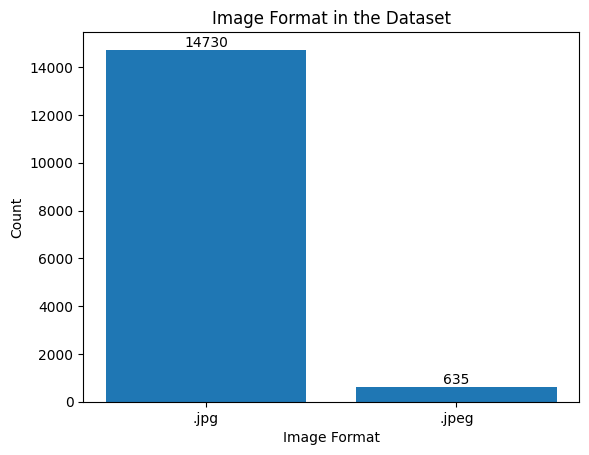

In [5]:
# Get the image formats and visualize as a graph
image_formats = {}
for _, img_path in full_custom_dataset.image_list:
    image_format = os.path.splitext(img_path)[1].lower()
    if image_format in image_formats:
        image_formats[image_format] += 1
    else:
        image_formats[image_format] = 1

formats = list(image_formats.keys())
counts = list(image_formats.values())

plt.bar(formats, counts)
plt.xlabel('Image Format')
plt.ylabel('Count')

# Display the count value on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Image Format in the Dataset')
plt.show()

The most common image format in the dataset is **JPG**, with **14730** images.

In [6]:
print(f'Fashion Item Categories : {full_custom_dataset.classes}')

Fashion Item Categories : ['Backpacks', 'Caps', 'Dresses', 'Handle Bags', 'Pants', 'Shirts', 'Shoes', 'Shorts', 'Sunglassess', 'Wallets', 'Watches']


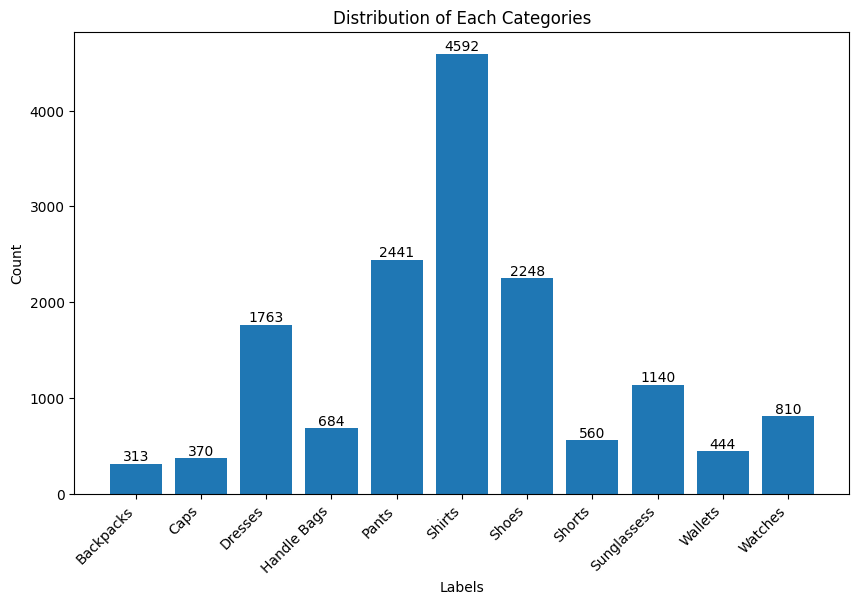

In [7]:
# Count occurrences of each category
category_counts = {label: 0 for label in full_custom_dataset.classes}
for label, _ in full_custom_dataset.image_list:
    category_counts[label] += 1

# Extract labels and counts for plotting
categories = list(category_counts.keys())
counts = list(category_counts.values())

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Each Categories')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability

# Annotate each bar with its count
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom')

plt.show()


Distribution Of Product Categories: The most popular category is **Shirts**.


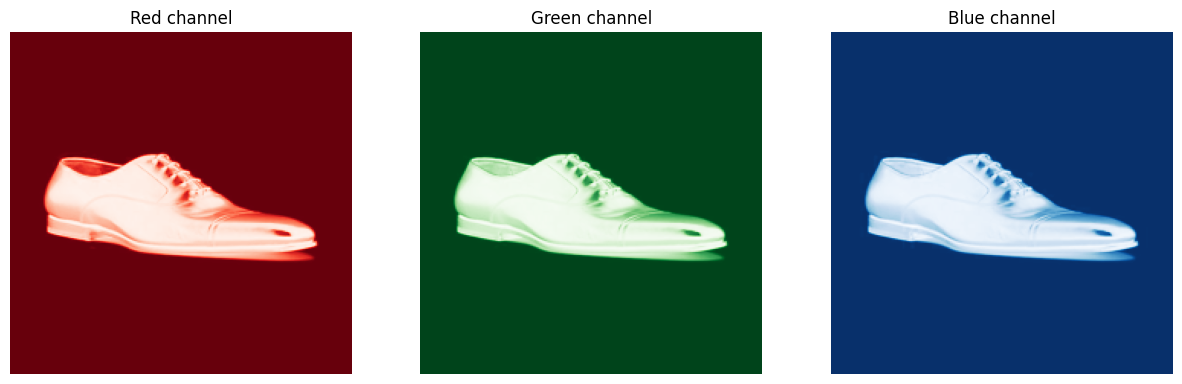

In [8]:
# Get a batch from the DataLoader
for _, image_names, images, _ in data_loader:
    # Extract the RGB image tensor of the first image in the batch
    rgb_image = images[0].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    
    # Display each color channel separately
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Display the Red channel
    axs[0].imshow(rgb_image[:, :, 0], cmap='Reds')
    axs[0].set_title('Red channel')
    axs[0].axis('off')

    # Display the Green channel
    axs[1].imshow(rgb_image[:, :, 1], cmap='Greens')
    axs[1].set_title('Green channel')
    axs[1].axis('off')

    # Display the Blue channel
    axs[2].imshow(rgb_image[:, :, 2], cmap='Blues')
    axs[2].set_title('Blue channel')
    axs[2].axis('off')

    plt.show()
    break  # Break after showing the first batch

A Pixel-Level Analysis : using the RGB (Red, Green, Blue) model

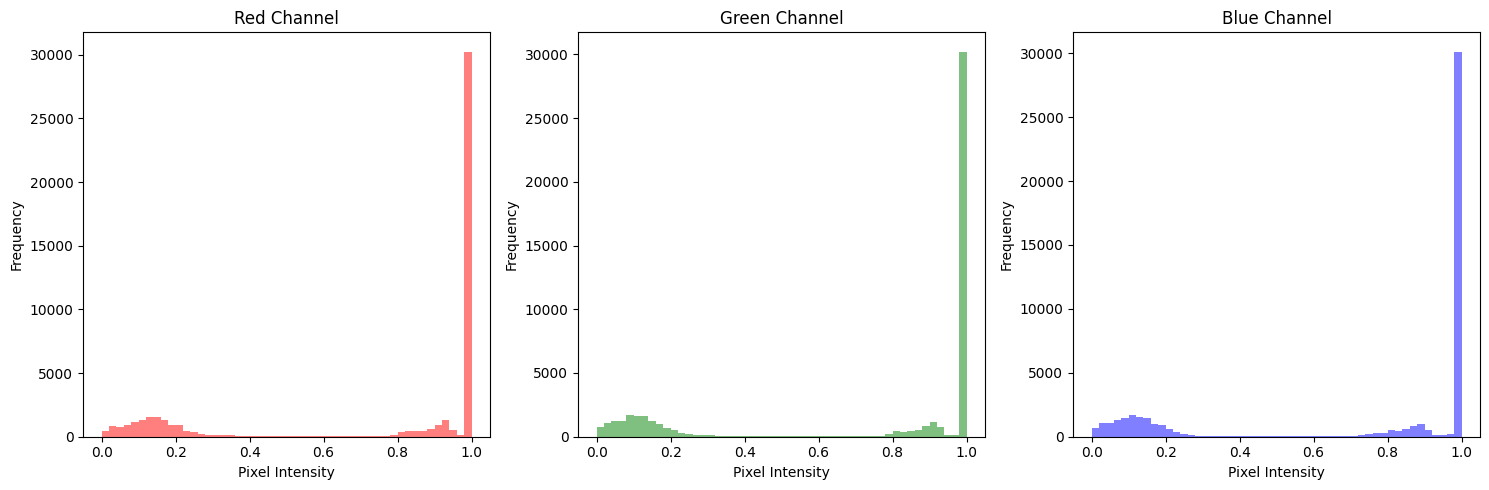

In [9]:
# Get the first batch from the DataLoader
for _, _, images, _ in data_loader:
    # Extract the RGB pixel values from the first image
    rgb_image = images[0].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    r_channel = rgb_image[:,:,0].flatten()
    g_channel = rgb_image[:,:,1].flatten()
    b_channel = rgb_image[:,:,2].flatten()

    # Plot the color distribution
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].hist(r_channel, bins=50, color='red', alpha=0.5)
    axs[0].set_title('Red Channel')
    axs[0].set_xlabel('Pixel Intensity')
    axs[0].set_ylabel('Frequency')
    
    axs[1].hist(g_channel, bins=50, color='green', alpha=0.5)
    axs[1].set_title('Green Channel')
    axs[1].set_xlabel('Pixel Intensity')
    axs[1].set_ylabel('Frequency')

    axs[2].hist(b_channel, bins=50, color='blue', alpha=0.5)
    axs[2].set_title('Blue Channel')
    axs[2].set_xlabel('Pixel Intensity')
    axs[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    
    break  # Break after showing the first batch

The distribution of pixel intensities suggests that the image have 3 channel contribute RED, GREEN and BLUE.

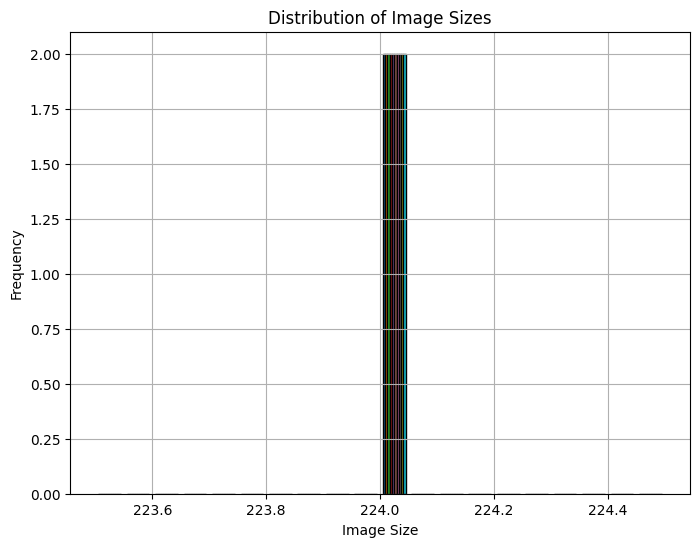

In [10]:
# Initialize a list to store sizes of the first 10 images
sizes = []

# Get a batch from the DataLoader
for _, image_names, images, _ in data_loader:
    # Extract the sizes of the first 10 images in the batch
    for image in images[:10]:
        sizes.append(image.shape[1:])  # Append the size of each image
    
    # Plot the distribution of sizes for the first 10 images
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(sizes, bins=20, edgecolor='black')
    ax.set_title('Distribution of Image Sizes')
    ax.set_xlabel('Image Size')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    plt.show()
    
    break  # Break after showing the first batch

Distribution Of Image Sizes  : the most common image size is around 224 bytes

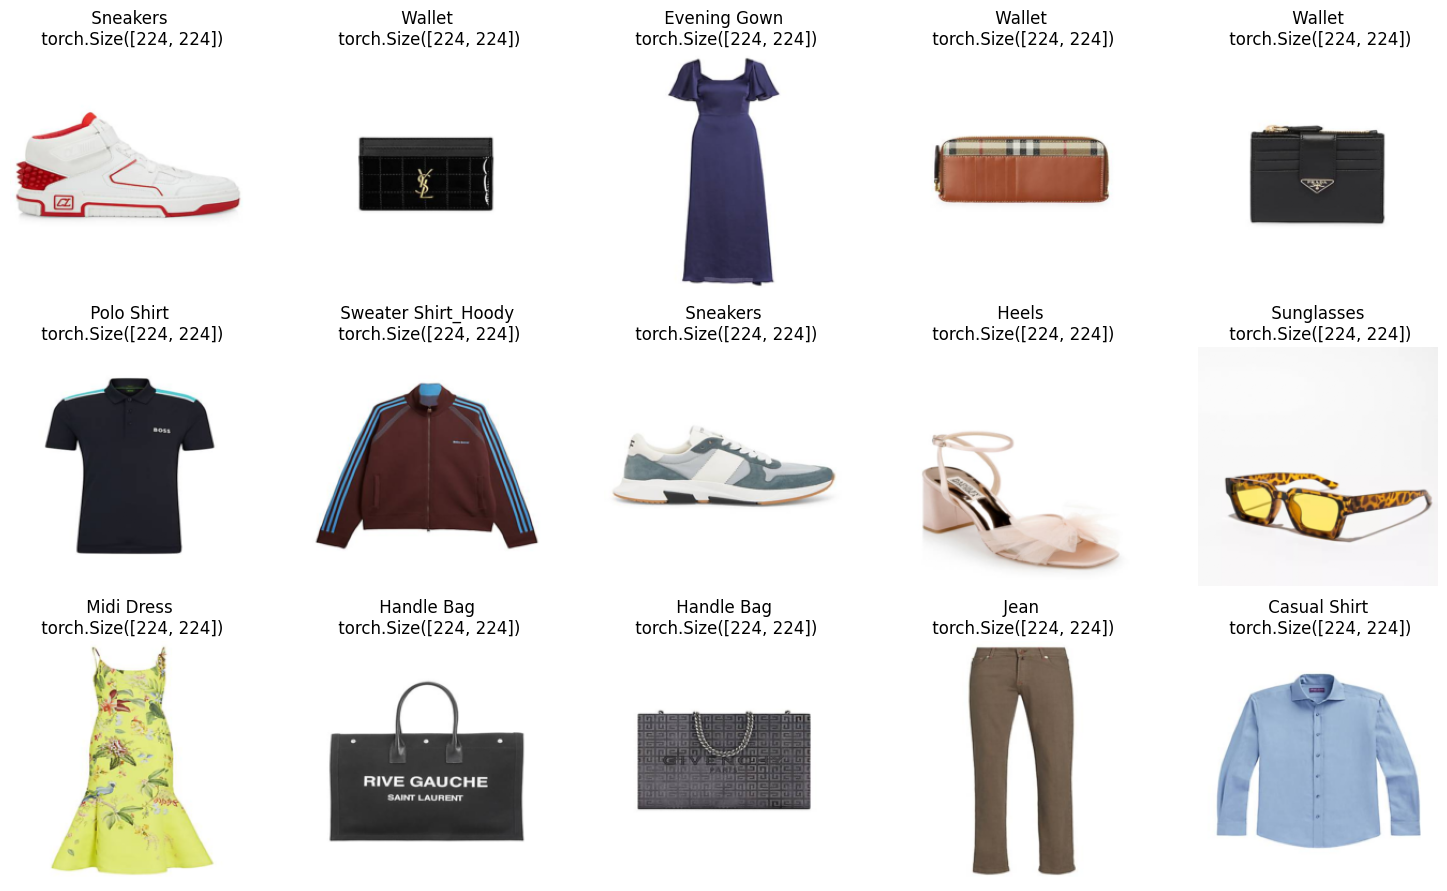

In [11]:
# Get a batch from the DataLoader
for _, image_names, images, _ in data_loader:
    # Display 15 images with 5 columns and 3 rows
    num_rows = 3
    num_cols = 5
    num_images_to_display = num_rows * num_cols
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 9))
    for i in range(num_images_to_display):
        # Extract the RGB image tensor
        rgb_image = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        
        # Determine the subplot position
        row = i // num_cols
        col = i % num_cols
        
        # Plot the image
        axs[row, col].imshow(rgb_image)
        axs[row, col].set_title(f" {image_names[i]} \n {images[i].shape[1:]}")
        axs[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    break  # Break after showing the first batch


# <span style="color:blue">Image Preprocessing</span>

- `transforms.Resize((224, 224))` resizes the images to a fixed size of 224x224 pixels.

- Additional transformations for data augmentation include:
  - `random_rotation`
  - `color_jitter`
  - `transforms.RandomHorizontalFlip()`
  - `horizontal_flip`

- `transforms.ToTensor()` converts the images to PyTorch tensor.

- `transforms.Normalize()` normalizes the tensor images with mean and standard deviation values commonly used for pre-trained models trained on the ageet dataset.



In [12]:
# Additional transformations for data augmentation
random_rotation = transforms.RandomRotation(degrees=30)
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
horizontal_flip = transforms.RandomHorizontalFlip()

# Image transforms
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

# <span style="color:blue">Feature Embedding Extraction</span>

### <span style="color:green">Baseline Pipeline for feature embedding extraction </span>

#### <span style="color:orange">Initialize a Pretrained Model:</span>
- This step involves loading a pre-trained convolutional neural network (CNN) model such as ResNet-18, ResNet-50, or VGG-16 using the torchvision library. These models are pre-trained on large image datasets to extract meaningful features from images.

#### <span style="color:orange">Select Layer for Feature Extraction:</span>
- The selected layer for feature extraction is usually one of the intermediate layers in the CNN, which captures rich, high-level features of the input image. In this project, we select the `avgpool` layer, which typically follows the convolutional layers and performs average pooling on the feature maps.

#### <span style="color:orange">Load Image Data:</span>
- This step involves loading an image from the file system using a library like PIL (Python Imaging Library) and preparing it for input to the neural network model. The image is typically resized to match the input size expected by the model and converted to a tensor.

#### <span style="color:orange">Image Transformation:</span>
- Image transformation involves applying preprocessing steps to the image data to make it suitable for input to the neural network model. Common transformations include resizing, normalization (scaling pixel values to a standard range), and converting the image to a tensor.

#### <span style="color:orange">Initialize Feature Vector Placeholder:</span>
- A placeholder for storing the extracted feature vector is initialized. This vector will hold the high-level features extracted by the selected layer of the neural network.

#### <span style="color:orange">Capture Selected Layer to Feature Vector:</span>
- A function is defined to copy the output of the selected layer (in this case, `avgpool`) to the feature vector placeholder. This function is registered as a hook to the layer, allowing us to intercept its output during the forward pass of the model.

#### <span style="color:orange">Forward Pass and Feature Extraction:</span>
- The transformed image is passed through the pre-trained model. During this process, the output of the selected layer (feature maps) is copied to the feature vector placeholder using the hook function.

#### <span style="color:orange">Remove the Hook After Feature Extraction:</span>
- After the feature extraction process is completed, the hook that was registered to capture the output of the selected layer is removed. This step is crucial to prevent memory leaks and ensure proper functioning of the model in subsequent operations. Removing the hook releases the resources associated with it and allows the model to operate normally without any interference.

#### <span style="color:orange">Convert Feature Vector to NumPy:</span>
- The feature vector, which is stored as a PyTorch tensor, is converted to a NumPy array for easier handling and compatibility with other libraries.

#### <span style="color:orange">Save as .npy File:</span>
- Finally, the extracted feature vector is saved as a `.npy` file using NumPy's `save` function. This file can be easily loaded and used for various machine learning tasks such as image classification, object detection, or image retrieval.


#### <span style="color:green">Define some helper functions </span>

**get_vector(image_path, model, layer, output_size):**
- This function takes an image path, a pre-trained neural network model, a layer within that model, and an output size as input. It preprocesses the image, passes it through the model until the specified layer, and extracts the feature vector from that layer's output.

**plot_scatter(feature_vectors, labels):**
- This function takes feature vectors and their corresponding labels as input. It uses Principal Component Analysis (PCA) to reduce the dimensionality of the feature vectors and then plots a scatter plot of the reduced features, where each point represents an image in the reduced feature space.

**PCA_Visualization(image_directory):**
- This function is meant to be used for visualizing the PCA analysis of feature vectors extracted from images. It loads images from the specified directory, extracts feature vectors using a pre-trained model, and then visualizes these feature vectors using PCA. It utilizes CustomImageDataset to load the dataset, creates a DataLoader to iterate over the dataset, extracts feature vectors, and finally plots the PCA scatter plot using the `plot_scatter` function.


In [13]:
def get_vector(image_path, model, layer, output_size, augment=True):
    # 1. Load the image with Pillow library
    image = Image.open(image_path)
    
    # 2. Create a PyTorch Variable with the transformed image (data augment)
    if augment:
      image = random_rotation(image)
      image = horizontal_flip(image)
      image = color_jitter(image)

    # 3. Data Preprocessing
    transformed_image = Variable(normalize(to_tensor(scaler(image))).unsqueeze(0))
    
    # 4. Create a vector of zeros that will hold our feature vector
    # Number of the output size of the 'avgpool' layer 
    my_embedding = torch.zeros(output_size)
    
    # 5. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
      my_embedding.copy_(o.data.reshape(o.data.size(1)))
        
    # 6. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)

    # 7. Run the model on our transformed image
    model(transformed_image)
    
    # 8. Detach our copy function from the layer
    h.remove()
    
    # 9. Return the feature vector
    return my_embedding.numpy()


In [14]:
# Define a function to display a single image with image name and feature vector
def show_image_with_info(image, label, feature_vector):
    plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for displaying with matplotlib
    plt.title(f"Label: {label}\nFeature Vector: {feature_vector}")
    plt.axis('off')
    plt.show()

In [15]:
# Define a function to plot scatter using PCA
def plot_scatter(feature_vectors, labels):
    
    pca = PCA(n_components=81)
    reduced_features = pca.fit_transform(feature_vectors)

    plt.figure(figsize=(10, 8))
    for label in set(labels):
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=label)

    plt.title('Scatter Plot of Images based on Feature Vectors (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

In [16]:
# Define a function to using data from dataloder to visualize PCA for gaining more insight on Feature Extraction using each pretrained model
def PCA_Visualization(image_directory):
    # Define the dataset
    custom_dataset = CustomImageDataset(root_dir=image_directory, transform=image_transform, include_feature_vector=True)

    # Define the DataLoader
    data_loader = DataLoader(dataset=custom_dataset, batch_size=len(custom_dataset), shuffle=True)

    # Get a batch from the DataLoader
    for labels, image_names, images, feature_vectors in data_loader:
        # Show the first image along with its label and feature vector
        # show_image_with_info(images[0], image_names[0], feature_vectors[0])
        break  # Break after showing the first batch
        
    # Plot PCA
    plot_scatter(feature_vectors.numpy(), labels)

In [17]:
# Get Testing Data
image_directory = 'Fashion_Items_For_Testing/'
custom_dataset = CustomImageDataset(root_dir=image_directory, transform=image_transform, include_feature_vector=False)

## &#x2B50; **<span style="color:violet">Resnet18</span>**   <!-- Glowing star -->


In [18]:
# Load the pretrained model
resnet18_model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer_of_resnet18 = resnet18_model._modules.get('avgpool')

# Set model to evaluation mode
resnet18_model.eval()

c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Call the process_images_and_save_vectors function
output_size = 512
custom_dataset.process_images_and_save_vectors(get_vector, resnet18_model, layer_of_resnet18, output_size)

Done


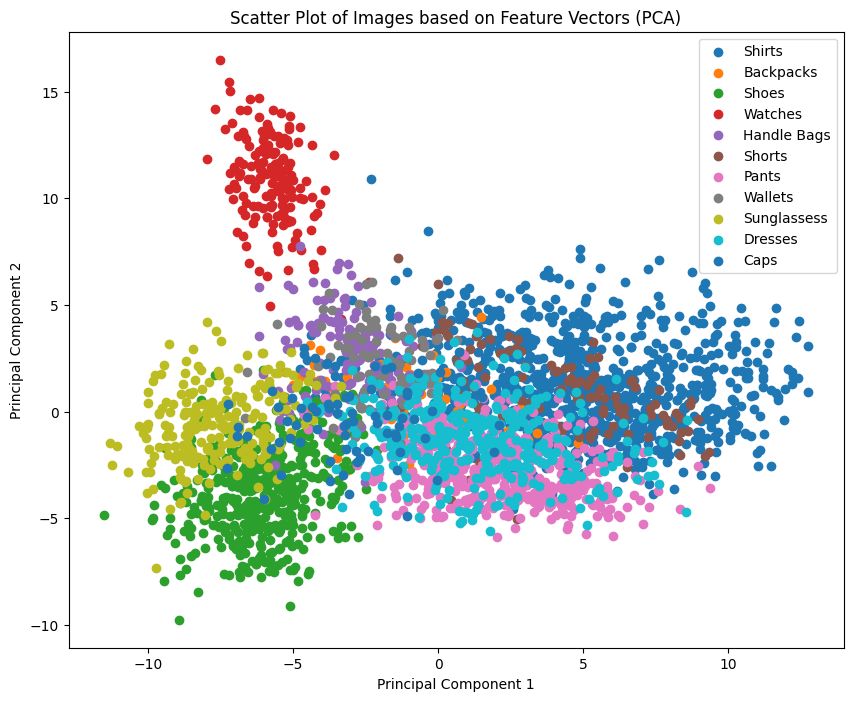

In [20]:
# Call PCA_Visualization
image_directory = 'Fashion_Items_For_Testing/'  # Replace with the actual directory path
PCA_Visualization(image_directory)

## &#x2B50; **<span style="color:violet">Resnet50</span>**   <!-- Glowing star -->


In [21]:
# Load the pretrained model
resnet50_model = models.resnet50(pretrained=True)

# Use the model object to select the desired layer
layer_of_resnet50 = resnet50_model._modules.get('avgpool')

# Set model to evaluation mode
resnet50_model.eval()

c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# Call the process_images_and_save_vectors function
output_size = 2048
custom_dataset.process_images_and_save_vectors(get_vector, resnet50_model, layer_of_resnet50, output_size)

Done


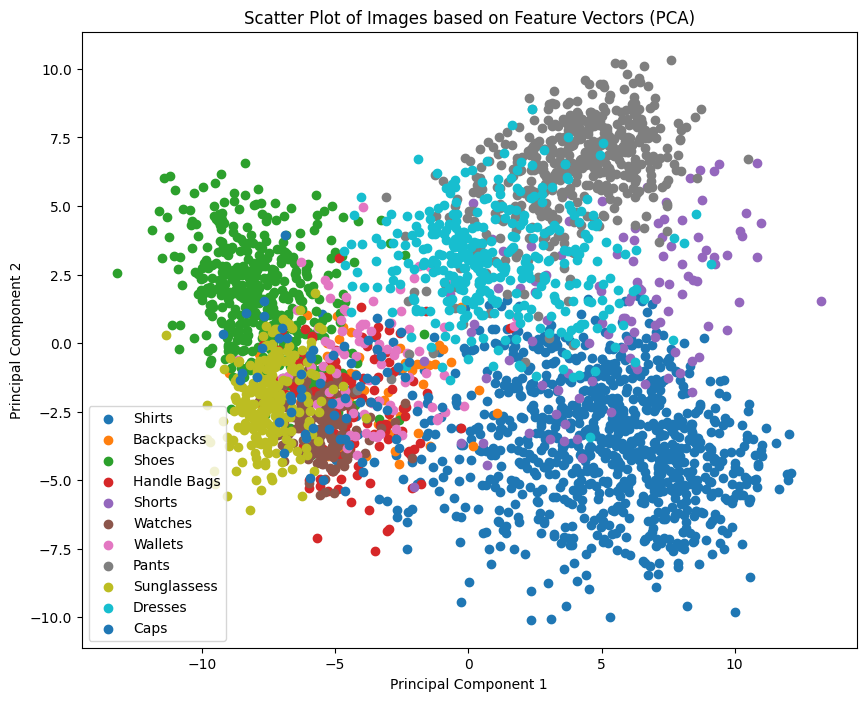

In [23]:
# Call PCA_Visualization
image_directory = 'Fashion_Items_For_Testing/'  # Replace with the actual directory path
PCA_Visualization(image_directory)


## &#x2B50; **<span style="color:violet">VGG16 ( In Progress )</span>**   <!-- Glowing star -->


In [24]:
# Load the pretrained model
vgg16_model = models.vgg16(pretrained=True)

# Use the model object to select the desired layer
layer = vgg16_model._modules.get('avgpool')

# Set model to evaluation mode
vgg16_model.eval()

c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
# Call the process_images_and_save_vectors function
# output_size = 4096
# custom_dataset.process_images_and_save_vectors(get_vector, vgg16_model, layer, output_size)

In [26]:
# Call PCA_Visualization
# image_directory = 'Fashion_Items_For_Testing/'  # Replace with the actual directory path
# PCA_Visualization(image_directory)

### <span style="color:orange">Now let's apply the best pretrained model</span>

In [27]:
# Define the dataset
image_directory = 'Fashion_Items_For_Testing/'  # Will Be Replace with the actual directory path of FULL DATASET
full_custom_dataset = CustomImageDataset(root_dir=image_directory, transform=image_transform, include_feature_vector=False)

# Call the process_images_and_save_vectors function
output_size = 2048
full_custom_dataset.process_images_and_save_vectors(get_vector, resnet50_model, layer_of_resnet50, output_size)

Done


#### PCA

In [28]:
plot_scatter(feature_vectors.numpy(), labels)

NameError: name 'feature_vectors' is not defined

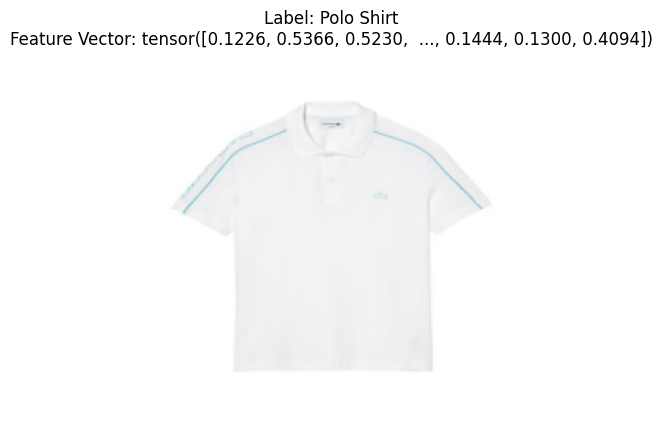

In [29]:
# Define the dataset
image_directory = 'Fashion_Items_For_Testing/'  # Will Be Replace with the actual directory path of FULL DATASET
full_custom_dataset = CustomImageDataset(root_dir=image_directory, transform=image_transform, include_feature_vector=True)

# Define the DataLoader
batch_size = 500
data_loader = DataLoader(dataset=full_custom_dataset, batch_size=batch_size, shuffle=True)
    
# Get a batch from the DataLoader (assuming batch size is 1)
for labels, image_names, images, feature_vectors in data_loader:
    # Show the first image along with its label and feature vector
    show_image_with_info(images[0], image_names[0], feature_vectors[0])
    break  # Break after showing the first batch

# <span style="color:blue">Image Similarity Computing</span>

### <span style="color:orange">Loading the Query Image :</span>
Load the query image using the provided path.

### <span style="color:orange">Extracting Features :</span>

Use the pre-trained model (like ResNet18) to extract features from the query image. This involves passing the image through the model and obtaining the feature vector.

### <span style="color:orange">Nearest Neighbors Search :</span>

Use the feature vectors of the dataset images and the query image's feature vector to perform a nearest neighbors search. This step finds the K images in the dataset that are most similar to the query image.

### <span style="color:orange">Displaying Results :</span>

Display the query image and the K nearest neighbor images along with their similarity percentages.


### <span style="color:green">Nearest Neighbors Search Process using KNN </span> using KNN

**Initializing Nearest Neighbors Algorithm:**
- Create an instance of the Nearest Neighbors algorithm (`knn`) with `K` neighbors and cosine similarity metric. Cosine similarity is often used when dealing with high-dimensional feature vectors.

**Fitting Feature Vectors:**
- Fit the Nearest Neighbors algorithm with the feature vectors of the dataset images. This step allows the algorithm to construct an efficient data structure for nearest neighbor queries.

**Computing Nearest Neighbors:**
- Use the fitted Nearest Neighbors algorithm to find the `K` nearest neighbors for the query image.
- Pass the feature vector of the query image to the `kneighbors` method, which returns the distances and indices of the `K` nearest neighbors in the dataset.

**Extracting Results:**
- Convert the distances and indices arrays to lists for easier manipulation (`distances_list` and `indices_list`).
- Each element in `distances_list` corresponds to the distance between the query image and its `K` nearest neighbors.
- Each element in `indices_list` corresponds to the index of the `K` nearest neighbor in the dataset.

**Visualizing Results:**
- Once the nearest neighbors are computed, visualize the results.
- Display the query image along with its title.
- Create a figure to display the `K` nearest neighbor images.
- Iterate over the `K` nearest neighbor indices and visualize each neighbor image along with its title, similarity percentage, and index.
- Similarity percentage is computed as `(1 - distance) * 100`, where distance is the cosine distance between the query image and the neighbor image.

**Displaying Plots:**
- Use Matplotlib to display the query image and the `K` nearest neighbor images in separate plots.

By following these steps, the `compute_similar_images` function effectively performs the Nearest Neighbors search to find the most similar images to the query image in the dataset.


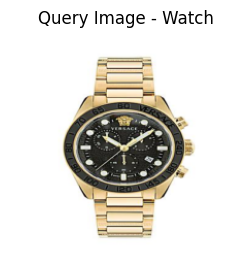

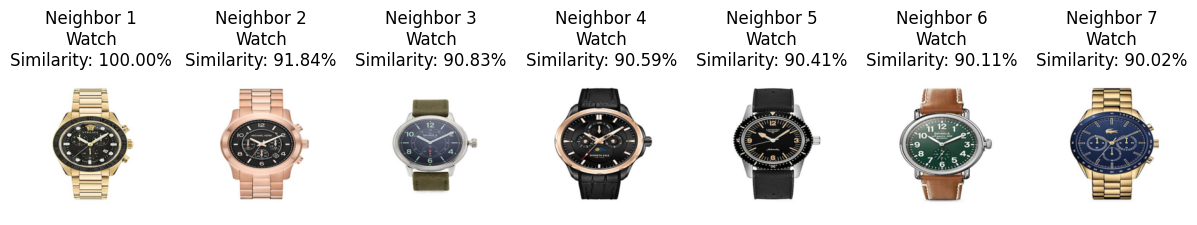

In [41]:
# Test with dataset
def compute_similar_images(query_index, feature_vectors, images, image_names, K=7):

    query_vector = feature_vectors[query_index].reshape(1, -1)

    knn = NearestNeighbors(n_neighbors=K, metric="cosine")
    knn.fit(feature_vectors)

    distances, indices = knn.kneighbors(query_vector)
    distances_list = distances.tolist()
    indices_list = indices.tolist()

    # Plot the query image
    plt.figure(figsize=(3, 3))
    plt.imshow(images[query_index].permute(1, 2, 0))
    plt.title(f"Query Image - {image_names[query_index]}")
    plt.axis('off')
    plt.show()

    # Plot the K-nearest neighbors
    plt.figure(figsize=(15, 5))
    for i in range(K):
        neighbor_index = indices_list[0][i]
        similarity_percentage = (1 - distances_list[0][i]) * 100  
        plt.subplot(1, K, i + 1)
        plt.imshow(images[neighbor_index].permute(1, 2, 0))
        plt.title(f"Neighbor {i + 1}\n{image_names[neighbor_index]}\nSimilarity: {similarity_percentage:.2f}%")
        plt.axis('off')
    plt.show()

    return indices_list

query_index = 21
indices_list = compute_similar_images(query_index, feature_vectors, images, image_names, K=7)


In [42]:
def evaluate_similarity(indices_list, query_index, image_names, K=7):
    query_name = image_names[query_index]

    matching_percentage = 0
    for i, neighbor_index in enumerate(indices_list[0]):
        neighbor_name = image_names[neighbor_index]
        if query_name == neighbor_name:
            matching_percentage += 1

    matching_percentage = (matching_percentage / K) * 100
    print(f"Matching Percentage: {matching_percentage:.2f}%")
    return matching_percentage

# Call the evaluate_similarity function
matching_percentage = evaluate_similarity(indices_list, query_index, image_names, K=7)


Matching Percentage: 100.00%


In [43]:
# Test with google data
def compute_similar_images_outside_data(query_image_path, feature_vectors, images, image_names, model, layer, output_size, K):

    query_vector = get_vector(query_image_path, model, layer, output_size, augment=False)

    # Use Nearest Neighbors to find similar images
    knn = NearestNeighbors(n_neighbors=K, metric="cosine")
    knn.fit(feature_vectors)

    # Find the K-nearest neighbors for the query image
    distances, indices = knn.kneighbors(query_vector.reshape(1, -1))  
    distances_list = distances.tolist()
    indices_list = indices.tolist()

    # Plot the query image
    query_image = Image.open(query_image_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(query_image)
    plt.title(f"Query Image")
    plt.axis('off')
    plt.show()

    # Plot the K-nearest neighbors
    plt.figure(figsize=(15, 5))
    for i in range(K):
        neighbor_index = indices_list[0][i]
        similarity_percentage = (1 - distances_list[0][i]) * 100  
        plt.subplot(1, K, i + 1)
        plt.imshow(images[neighbor_index].permute(1, 2, 0))
        plt.title(f"Neighbor {i + 1}\n{image_names[neighbor_index]}\nSimilarity: {similarity_percentage:.2f}%")
        plt.axis('off')
    plt.show()

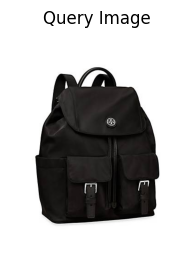

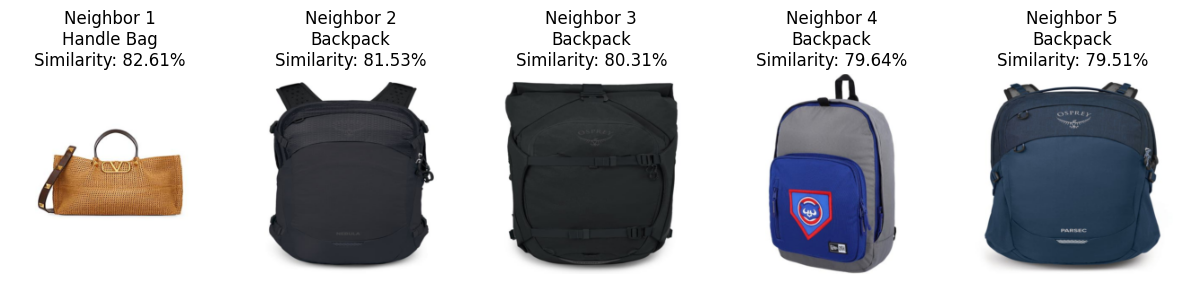

In [45]:
query_image_path = "Fashion_Items_Dataset/Backpacks/Backpack/Backpack02.jpg"
output_size = 2048
# Find K-nearest neighbors for the provided query image
compute_similar_images_outside_data(query_image_path, feature_vectors, images, image_names, resnet50_model, layer_of_resnet50, output_size, K=5)